# Weather forecasts on ERA5

This notebook shows how to initialize the Dinosaur dynamical core to perform a retrospective weather forecast initialized with ERA5.

It shows:

1. How to construct a Dinosaur initial state from reanalysis data, including data loading and unit conversion.
2. How to filter initial conditions using [digital filter initialization](https://journals.ametsoc.org/view/journals/mwre/120/6/1520-0493_1992_120_1019_iothmu_2_0_co_2.xml), which creates much better looking weather forecasts.
3. How to selectively calculated diagnostic quantity (e.g., vertical wind and geopotential) from the Dinosuar states.

Note: This notebook runs well on TPU v5e kernel in Google Colab. It also runs on an A100 GPU, but the compile time for some operations is quite slow (~6 minutes vs ~30 seconds) -- we are looking into this.

## Setup code

### Installation

### Imports

In [1]:
import dinosaur, inspect
print(inspect.getfile(dinosaur))


/home/gmathieu/venvs/jcm-gpu/lib/python3.11/site-packages/dinosaur/__init__.py


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray

from dinosaur import coordinate_systems
from dinosaur import filtering
from dinosaur import primitive_equations
from dinosaur import scales
from dinosaur import sigma_coordinates
from dinosaur import spherical_harmonic
from dinosaur import time_integration
from dinosaur import vertical_interpolation

units = scales.units

### Utilities

In [3]:

def attach_data_array_units(array):
  attrs = dict(array.attrs)
  units = attrs.pop('units', None)
  if units in {'(0 - 1)', '%', '~'}:
    units = None
  if units is not None:
    data = scales.units.parse_expression(units) * array.data
  else:
    data = scales.units.dimensionless * array.data
  return xarray.DataArray(data, array.coords, array.dims, attrs=attrs)


def attach_xarray_units(ds):
  return ds.map(attach_data_array_units)


def xarray_nondimensionalize(ds):
  return xarray.apply_ufunc(scales.DEFAULT_SCALE.nondimensionalize, ds)


def xarray_to_gcm_dict(ds, var_names=None):
  if var_names is None:
    var_names = ds.keys()
  result = {}
  for var_name in var_names:
    data = ds[var_name].transpose(..., 'longitude', 'latitude').data
    if data.ndim == 2:  # missing level dimension
      data = data[np.newaxis, ...]
    result[var_name] = data
  return result


def slice_levels(output, level_indices):
  def get_horizontal(x):
    if x.shape[0] == 1:
      return x
    else:
      return x[level_indices, ...]
  return jax.tree.map(get_horizontal, output)


### Config desired outputs

In [4]:
# simulation grid
layers = 32
ref_temp_si = 250 * units.degK
model_coords = coordinate_systems.CoordinateSystem(
    spherical_harmonic.Grid.T170(),
    sigma_coordinates.SigmaCoordinates.equidistant(layers),
)

# timescales
dt_si = 5 * units.minute
save_every = 12 * units.hour
total_time = 2 * units.day + save_every   # garde le +save_every si tu veux inclure le dernier point (48h)
dfi_timescale = 6 * units.hour            # tu peux laisser comme ça


# which levels to output
output_level_indices = [layers // 4, layers // 2, 3*layers // 4, -1]


### Load source data

In [5]:
import dinosaur
print(dinosaur.__file__)



/home/gmathieu/venvs/jcm-gpu/lib/python3.11/site-packages/dinosaur/__init__.py


In [6]:
import xarray as xr
ds = xr.open_dataset("/scratch/gmathieu/era5_snapshot/era5_19900501T00.nc", engine="scipy")
ds


raw_orography = ds.geopotential_at_surface




In [7]:
import os
p="/scratch/gmathieu/era5_snapshot/era5_19900501T00.nc"
print("exists:", os.path.exists(p), "size:", os.path.getsize(p) if os.path.exists(p) else None)


exists: True size: 3422070680


In [8]:
import xarray as xr
ds_arco_era5 = xr.open_dataset(p, engine="scipy")
print(ds_arco_era5.data_vars.keys())


KeysView(Data variables:
    surface_pressure                     (latitude, longitude) float32 4MB ...
    geopotential_at_surface              (latitude, longitude) float32 4MB ...
    u_component_of_wind                  (hybrid, latitude, longitude) float32 569MB ...
    v_component_of_wind                  (hybrid, latitude, longitude) float32 569MB ...
    temperature                          (hybrid, latitude, longitude) float32 569MB ...
    specific_humidity                    (hybrid, latitude, longitude) float32 569MB ...
    specific_cloud_liquid_water_content  (hybrid, latitude, longitude) float32 569MB ...
    specific_cloud_ice_water_content     (hybrid, latitude, longitude) float32 569MB ...)


In [9]:
desired_lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
desired_lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])

ds_init = attach_xarray_units(ds.compute().interp(latitude=desired_lat, longitude=desired_lon))
ds_init['orography'] = attach_data_array_units(raw_orography.interp(latitude=desired_lat, longitude=desired_lon))
ds_init['orography'] /= scales.GRAVITY_ACCELERATION

from dinosaur import hybrid_coordinates
source_vertical = hybrid_coordinates.HybridCoordinates.ECMWF137()


### Build initial conditions

In [10]:
# nondimensionalize
ds_nondim_init = xarray_nondimensionalize(ds_init)
model_level_inputs = xarray_to_gcm_dict(ds_nondim_init)

sp_nodal = model_level_inputs.pop('surface_pressure')
orography_input = model_level_inputs.pop('orography')

sp_init_hpa = ds_init.surface_pressure.transpose('longitude', 'latitude').data.to('hPa').magnitude

# build inputs
physics_specs = primitive_equations.PrimitiveEquationsSpecs.from_si()

# retirer champs surface qui ne sont PAS hybrides
model_level_inputs.pop("geopotential_at_surface", None)
model_level_inputs.pop("surface_pressure", None)   # au cas où
model_level_inputs.pop("orography", None)          # au cas où


nodal_inputs = vertical_interpolation.regrid_hybrid_to_sigma(
    fields=model_level_inputs,
    hybrid_coords=source_vertical,
    sigma_coords=model_coords.vertical,
    surface_pressure=sp_init_hpa,
)
u_nodal = nodal_inputs['u_component_of_wind']
v_nodal = nodal_inputs['v_component_of_wind']
t_nodal = nodal_inputs['temperature']

# calculate vorticity & divergence
vorticity, divergence = spherical_harmonic.uv_nodal_to_vor_div_modal(
    model_coords.horizontal, u_nodal, v_nodal
)

# apply reference temperature
ref_temps = physics_specs.nondimensionalize(
    ref_temp_si * np.ones((model_coords.vertical.layers,))
)

assert ref_temps.shape == (model_coords.vertical.layers,)
temperature_variation = model_coords.horizontal.to_modal(
    t_nodal - ref_temps.reshape(-1, 1, 1)
)

log_sp = model_coords.horizontal.to_modal(np.log(sp_nodal))
tracers = model_coords.horizontal.to_modal(
    {
        'specific_humidity': nodal_inputs['specific_humidity'],
        'specific_cloud_liquid_water_content': nodal_inputs['specific_cloud_liquid_water_content'],
        'specific_cloud_ice_water_content': nodal_inputs['specific_cloud_ice_water_content'],
    }
)

# build initial state
raw_init_state = primitive_equations.State(
    vorticity=vorticity,
    divergence=divergence,
    temperature_variation=temperature_variation,
    log_surface_pressure=log_sp,
    tracers=tracers,
)

orography = model_coords.horizontal.to_modal(orography_input)
orography = filtering.exponential_filter(model_coords.horizontal, order=2)(orography)


W0216 15:31:44.277971 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
E0216 15:33:44.275222 3814455 slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_regrid_hybrid_to_sigma for GPU] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
E0216 15:35:06.829596 3814283 slow_operation_alarm.cc:140] The operation took 3m22.5544409s

********************************
[Compiling module jit_regrid_hybrid_to_sigma for GPU] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
W0216 15:35:08.935329 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:35:09.030541 3814451 sol_gpu_cost_model.cc:102] No SoL config found f

### Setup dycore and digital filter initialization

In [11]:
# setup a simulation of the dry primitive equations
eq = primitive_equations.PrimitiveEquations(
    ref_temps, orography, model_coords, physics_specs
)

# setup hyper-spectral filter for running between dycore time-steps
res_factor = model_coords.horizontal.latitude_nodes / 128
dt = physics_specs.nondimensionalize(dt_si)
tau = physics_specs.nondimensionalize(8.6 / (2.4 ** np.log2(res_factor)) * units.hours)
hyperdiffusion_filter = time_integration.horizontal_diffusion_step_filter(
    model_coords.horizontal, dt=dt, tau=tau, order=2
)

# digital filter initialization
time_span = cutoff_period = physics_specs.nondimensionalize(dfi_timescale)
dfi = jax.jit(time_integration.digital_filter_initialization(
    equation=eq,
    ode_solver=time_integration.imex_rk_sil3,
    filters=[hyperdiffusion_filter],
    time_span=time_span,
    cutoff_period=cutoff_period,
    dt=dt,
))
%time dfi_init_state = jax.block_until_ready(dfi(raw_init_state))

W0216 15:35:54.008495 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:35:54.025072 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:35:54.039039 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:35:54.061824 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:35:54.076385 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:35:54.091550 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:35:54.105743 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. 

CPU times: user 27.6 s, sys: 4.76 s, total: 32.4 s
Wall time: 36.8 s


### Setup time integration & post-processing

In [12]:
# time integration & post-processing

def nodal_prognostics_and_diagnostics(state):
  coords = model_coords.horizontal
  u_nodal, v_nodal = spherical_harmonic.vor_div_to_uv_nodal(
      coords, state.vorticity, state.divergence)
  geopotential_nodal = coords.to_nodal(
      primitive_equations.get_geopotential(
          state.temperature_variation,
          eq.reference_temperature,
          orography,
          model_coords.vertical,
          physics_specs.gravity_acceleration,
          physics_specs.ideal_gas_constant,
      )
  )
  vor_nodal = coords.to_nodal(state.vorticity)
  div_nodal = coords.to_nodal(state.divergence)
  sp_nodal = jnp.exp(coords.to_nodal(state.log_surface_pressure))
  tracers_nodal = {k: coords.to_nodal(v) for k, v in state.tracers.items()}
  t_nodal = (
      coords.to_nodal(state.temperature_variation)
      + ref_temps[:, np.newaxis, np.newaxis]
  )
  vertical_velocity_nodal = primitive_equations.compute_vertical_velocity(
      state, model_coords
  )
  state_nodal = {
      'u_component_of_wind': u_nodal,
      'v_component_of_wind': v_nodal,
      'temperature': t_nodal,
      'vorticity': vor_nodal,
      'divergence': div_nodal,
      'vertical_velocity': vertical_velocity_nodal,
      'geopotential': geopotential_nodal,
      'surface_pressure': sp_nodal,
      **tracers_nodal,
  }
  return slice_levels(state_nodal, output_level_indices)


def trajectory_to_xarray(trajectory):

  # convert units back to SI
  target_units = {k: v.data.units for k, v in ds_init.items()}
  target_units |= {
      'vorticity': units('1/s'),
      'divergence': units('1/s'),
      'geopotential': units('m^2/s^2'),
      'vertical_velocity': units('1/s'),
  }

  orography_nodal = jax.device_put(model_coords.horizontal.to_nodal(orography), device=jax.devices('cpu')[0])
  trajectory_cpu = jax.device_put(trajectory, device=jax.devices('cpu')[0])

  traj_nodal_si = {
      k: physics_specs.dimensionalize(v, target_units[k]).magnitude
      for k, v in trajectory_cpu.items()
  }

  # build xarray
  times = float(save_every / units.hour) * np.arange(outer_steps)
  lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
  lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])

  dims = ('time', 'sigma', 'longitude', 'latitude')
  ds_result = xarray.Dataset(
      data_vars={
          k: (dims, v) for k, v in traj_nodal_si.items() if k != 'surface_pressure'
      },
      coords={
          'longitude': lon,
          'latitude': lat,
          'sigma': model_coords.vertical.centers[output_level_indices],
          'time': times,
          'orography': (('longitude', 'latitude'), orography_nodal.squeeze()),
      },
  ).assign(
      surface_pressure=(
          ('time', 'longitude', 'latitude'),
          traj_nodal_si['surface_pressure'].squeeze(axis=-3),
      )
  )
  return ds_result

# temporal integration function
inner_steps = int(save_every / dt_si)
outer_steps = int(total_time / save_every)
step_fn = time_integration.step_with_filters(
    time_integration.imex_rk_sil3(eq, dt),
    [hyperdiffusion_filter],
)
integrate_fn = jax.jit(time_integration.trajectory_from_step(
    step_fn,
    outer_steps=outer_steps,
    inner_steps=inner_steps,
    start_with_input=True,
    post_process_fn=nodal_prognostics_and_diagnostics,
))

## Calculate outputs

For cases where you need to output more data than you have available CPU memory, `integrate_fn` should be called in a loop, with `out_state` passed into the next function call as shown in under [advancing in time](https://neuralgcm.readthedocs.io/en/latest/trained_models.html#advancing-in-time) in the NeuralGCM documentation.

In [13]:
%time out_state, trajectory = jax.block_until_ready(integrate_fn(dfi_init_state))
ds_out = trajectory_to_xarray(trajectory)

W0216 15:37:31.092164 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:37:31.120956 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:37:31.556050 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.


CPU times: user 20.7 s, sys: 15.4 s, total: 36.1 s
Wall time: 1min 7s


W0216 15:38:05.516695 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:38:05.577024 3814451 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:38:05.592132 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.


In [14]:
#%time out_state, trajectory = jax.block_until_ready(integrate_fn(raw_init_state))
#ds_out_unfiltered = trajectory_to_xarray(trajectory)

In [15]:
ds_out

<xarray.Dataset> Size: 108MB
Dimensions:                              (time: 5, sigma: 4, longitude: 512,
                                          latitude: 256)
Coordinates:
  * time                                 (time) float64 40B 0.0 12.0 ... 48.0
  * sigma                                (sigma) float32 16B 0.2656 ... 0.9844
  * longitude                            (longitude) float64 4kB 0.0 ... 359.3
  * latitude                             (latitude) float64 2kB -89.46 ... 89.46
    orography                            (longitude, latitude) float32 524kB ...
Data variables:
    divergence                           (time, sigma, longitude, latitude) float32 10MB ...
    geopotential                         (time, sigma, longitude, latitude) float32 10MB ...
    specific_cloud_ice_water_content     (time, sigma, longitude, latitude) float32 10MB ...
    specific_cloud_liquid_water_content  (time, sigma, longitude, latitude) float32 10MB ...
    specific_humidity                    (time, sigma, longitude, latitude) float32 10MB ...
    temperature                          (time, sigma, longitude, latitude) float32 10MB ...
    u_component_of_wind                  (time, sigma, longitude, latitude) float32 10MB ...
    v_component_of_wind                  (time, sigma, longitude, latitude) float32 10MB ...
    vertical_velocity                    (time, sigma, longitude, latitude) float32 10MB ...
    vorticity                            (time, sigma, longitude, latitude) float32 10MB ...
    surface_pressure                     (time, longitude, latitude) float32 3MB ...

## Analyze outputs

### Digital filter initialization (DFI)

Short of variational data assimilation, digital filter initialization is useful to avoid very rapid oscillations in weather forecasts. This is particularly evidence for the surface pressure field:

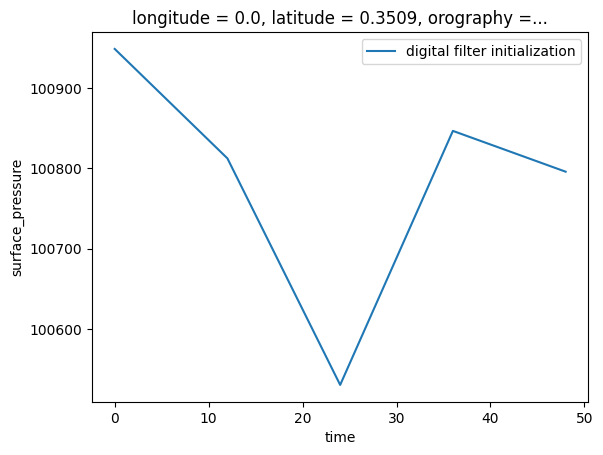

In [16]:
ds_out.surface_pressure.sel(latitude=0, longitude=0, method='nearest').plot.line(label='digital filter initialization');
#ds_out_unfiltered.surface_pressure.sel(latitude=0, longitude=0, method='nearest').plot.line(label='unfiltered');
plt.legend()

### Visualize forecasts

This is a dycore only model, so physical variables are not necessarily not guaranteed to stay "reasonable."

For example, specific humidity increases to a unrealistically large maximum value at the middle sigma level:

W0216 15:38:12.453834 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:38:12.479459 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:38:12.520539 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:38:12.564391 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.
W0216 15:38:12.607939 3814283 sol_gpu_cost_model.cc:102] No SoL config found for device: NVIDIA H100 80GB HBM3 MIG 2g.20gb. Using default config.


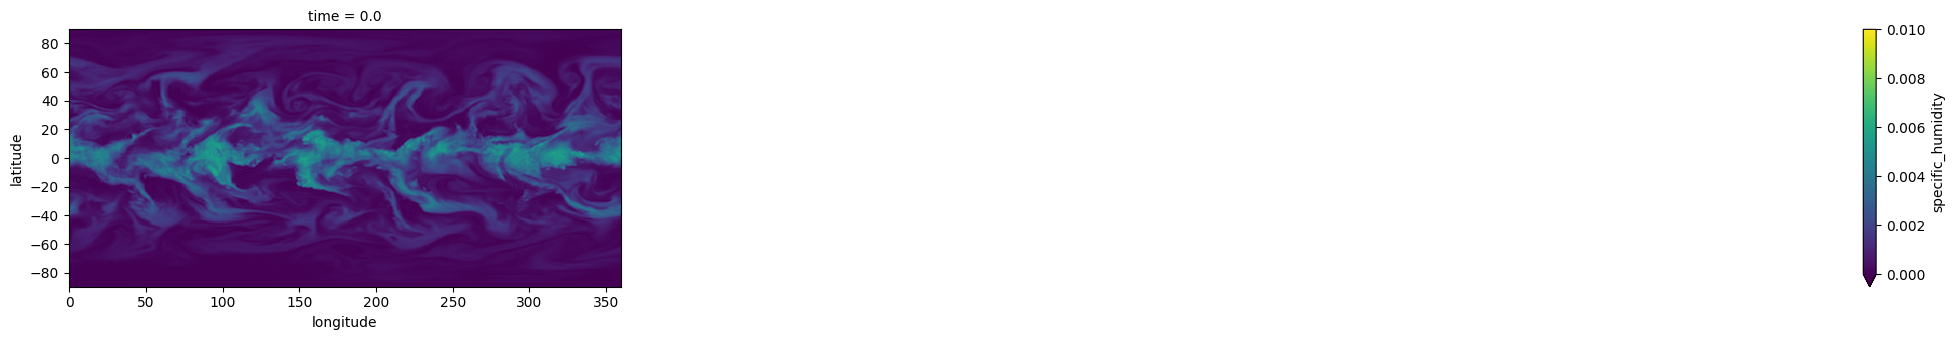

In [17]:
ds_out.specific_humidity.thin(time=4*24).isel(sigma=1).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=3, aspect=2, size=3.5,
    cmap='viridis', vmin=0, vmax=0.01,
)

As another example, cloud liquid water content has a very non-smooth initial condition, so it takes on some slightly negative values after evolution by the dycore. This could be fixed with additional filtering of initial conditions or by implementing an alternative advection scheme in Dinosaur (some form of limiter to ensure monotonic behavior):

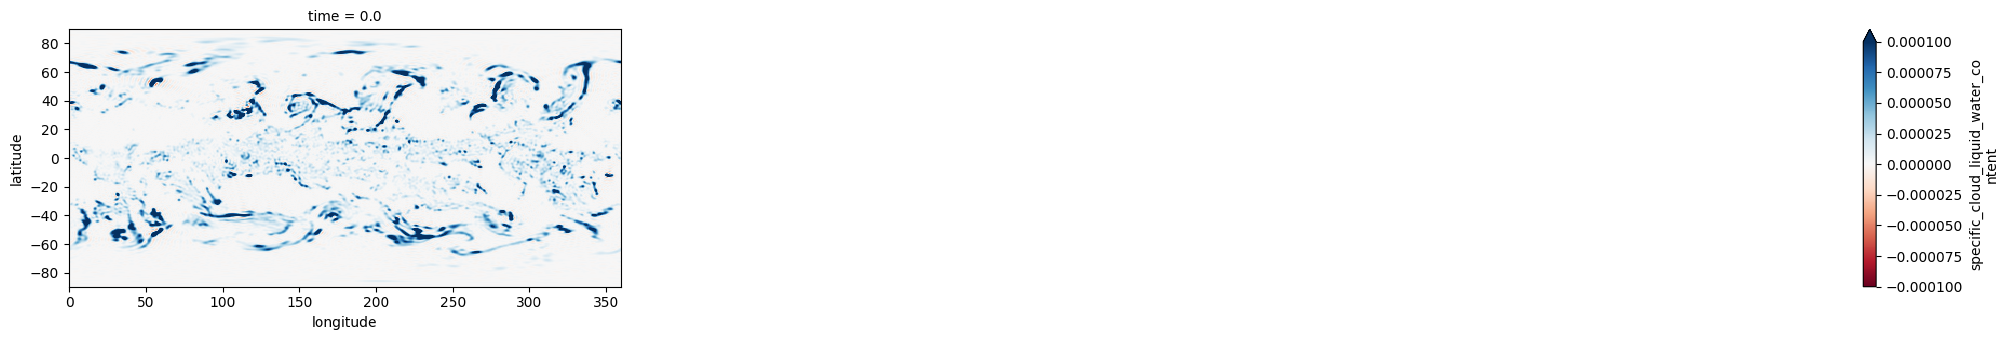

In [18]:
ds_out.specific_cloud_liquid_water_content.thin(time=4*24).isel(sigma=2).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=3, aspect=2, size=3.5,
    cmap='RdBu', vmin=-1e-4, vmax=1e-4,
)

In [19]:
import os
import xarray as xr

out_dir = "/scratch/gmathieu/dinosaur_outputs"
os.makedirs(out_dir, exist_ok=True)

vars_keep = [v for v in ds_out.data_vars if v in ["u", "v", "temperature", "surface_pressure"]]
ds_small = ds_out[vars_keep].astype("float32").load()

out_path = "/scratch/gmathieu/dinosaur_outputs/ds_out_dino_2days_12h.nc"

ds_small.to_netcdf(out_path, engine="scipy", format="NETCDF3_64BIT")
print("WROTE:", out_path)


# (recommandé) convertir en float32 pour réduire taille
ds_to_save = ds_out.astype("float32")

# (recommandé) s'assurer que ce sont des numpy arrays (pas de DeviceArray)
ds_to_save = ds_to_save.load()

ds_to_save.to_netcdf(
    out_path,
    engine="scipy",
    format="NETCDF3_64BIT",
)

print("WROTE:", out_path, "size_MB=", os.path.getsize(out_path)/1e6)


WROTE: /scratch/gmathieu/dinosaur_outputs/ds_out_dino_2days_12h.nc
WROTE: /scratch/gmathieu/dinosaur_outputs/ds_out_dino_2days_12h.nc size_MB= 108.011444


In [20]:
print("n_time =", ds_small.sizes["time"])
print(ds_small["time"].values)


n_time = 5
[ 0. 12. 24. 36. 48.]
